In [1]:
import tensorflow as tf

print(tf.keras.__version__)

2.5.0


In [2]:
! git clone https://github.com/credo-ml/cnn-offline-trigger.git
    
! unzip ./cnn-offline-trigger/data-set.zip
! pip install mahotas    


Cloning into 'cnn-offline-trigger'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
Archive:  ./cnn-offline-trigger/data-set.zip
   creating: hit-images-final/
   creating: hit-images-final/artefacts/
 extracting: hit-images-final/artefacts/10219929.png  
 extracting: hit-images-final/artefacts/10219931.png  
 extracting: hit-images-final/artefacts/10223942.png  
 extracting: hit-images-final/artefacts/10228003.png  
 extracting: hit-images-final/artefacts/10231268.png  
 extracting: hit-images-final/artefacts/10231560.png  
 extracting: hit-images-final/artefacts/10232861.png  
 extracting: hit-images-final/artefacts/10233802.png  
 extracting: hit-images-final/artefacts/10235049.png  
 extracting: hit-images-final/artefacts/10235948.png  
 extracting: hit-images-final/artefacts/10245995.png  
 ext

In [3]:
def loadData(path, verbose=True):

  import cv2
  import glob

  dots = []
  lines = []
  worms = []
  artefacts = []

  for img in glob.glob(path+"hits_votes_4_Dots/*.png"):
      n = cv2.imread(img)
      dots.append(n)
  target_dots = [0 for _ in dots]

  for img in glob.glob(path+"hits_votes_4_Lines/*.png"):
      n = cv2.imread(img)
      lines.append(n)
  target_lines = [1 for _ in lines]

  for img in glob.glob(path+"hits_votes_4_Worms/*.png"):
      n = cv2.imread(img)
      worms.append(n)
  target_worms = [2 for _ in worms]

  for img in glob.glob(path+"artefacts/*.png"):
      n = cv2.imread(img)
      artefacts.append(n)
  target_artefacts = [3 for _ in artefacts]

  images=dots+lines+worms+artefacts

  target_signals_binary = [0 for _ in (dots+lines+worms)]
  target_artefacts_binary = [1 for _ in artefacts]

  targets=target_signals_binary+target_artefacts_binary

  if verbose:
    print(len(images),len(targets))
    print(images[0].shape)
    print(len(dots), len(lines), len(worms), len(artefacts))


  return (images, targets)

In [4]:
# path="/content/drive/MyDrive/Colab Notebooks/hit-images/"
path="hit-images-final/"

images, targets = loadData(path)

2354 2354
(60, 60, 3)
535 393 304 1122


In [5]:

def preprocessData(data, wavelets=(2,), verbose=True):

  import mahotas
  import numpy as np

  print(wavelets)

  images, targets = data

  features = []
  bl_images = []
  th_images = []

  for img in images:

    img = img.astype('int32')

    blackwhite=img[:,:,0]+img[:,:,1]+img[:,:,2]
    bl_images.append(blackwhite.copy())

    threshold = blackwhite.mean() + blackwhite.std() * 5
    threshold = threshold if threshold < 100 else 100  

    mask = np.where(blackwhite > threshold, 1, 0)
    blackwhite = blackwhite * mask

    th_images.append(blackwhite.copy())


    # Transform using Dx Wavelets to obtain transformed images

    layers = {
      'raw':img.reshape(60,60,3),         
      0: blackwhite.reshape(60,60,1),        
      2: mahotas.daubechies(blackwhite,'D2').reshape(60,60,1),
      4: mahotas.daubechies(blackwhite,'D4').reshape(60,60,1),
      6: mahotas.daubechies(blackwhite,'D6').reshape(60,60,1),
      8: mahotas.daubechies(blackwhite,'D8').reshape(60,60,1),
      10: mahotas.daubechies(blackwhite,'D10').reshape(60,60,1),
      12: mahotas.daubechies(blackwhite,'D12').reshape(60,60,1),
      14: mahotas.daubechies(blackwhite,'D14').reshape(60,60,1),
      16: mahotas.daubechies(blackwhite,'D16').reshape(60,60,1),
      18: mahotas.daubechies(blackwhite,'D18').reshape(60,60,1),
      20: mahotas.daubechies(blackwhite,'D20').reshape(60,60,1)
    }

    # tt = np.concatenate((t02, t04, t06, t08), axis=2)
    out = np.concatenate(tuple(map(layers.__getitem__, wavelets)), axis=2)

    features.append(out)

  feature_array, label_array = np.array(features), np.array(targets)

  if verbose:
    print(feature_array.shape)
    print(label_array.shape)

  return (feature_array, label_array, th_images, bl_images)


In [6]:
feature_array, label_array, th, bl = preprocessData(data=(images, targets), wavelets=(20,))

(20,)
(2354, 60, 60, 1)
(2354,)


In [7]:
import tensorflow as tf
import time
begin = time.time()
print(f"TensorFlow version: {tf.__version__}")
#import keras (high level API) wiht tensorflow as backend
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape, verbose=True):
    model = Sequential()
    
        
####  SMALL MODEL
    # 2 Convolution layer with Max polling
    model.add(Conv2D(16, 3, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(Conv2D(16, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D(pool_size = (2,2)))
    # model.add(Dropout(0.2))
    model.add(Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(Conv2D(16, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D(pool_size = (2,2)))  
    # model.add(Dropout(0.2))
    model.add(Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(Conv2D(16, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D(pool_size = (2,2)))    
    # model.add(Dropout(0.2))
    model.add(Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(Conv2D(16, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D(pool_size = (2,2)))        
    model.add(Flatten())  
    # 3 Full connected layer
    model.add(Dense(300, activation = activation, kernel_initializer = "he_normal", 
                    kernel_regularizer=tf.keras.regularizers.l1(0.01),
                    activity_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(50, activation = activation, kernel_initializer = "he_normal", 
                    kernel_regularizer=tf.keras.regularizers.l1(0.01),
                    activity_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(2, activation = 'softmax')) # 6 classes
    
    # summarize the model
    if verbose:
      print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs, verbose=True):

    # compile the model
    model.compile(
        # optimizer=tf.keras.optimizers.Adam(),
        optimizer=tf.keras.optimizers.RMSprop(),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    model.save('init.model.h5')



    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

TensorFlow version: 2.5.0


In [8]:
from sklearn.model_selection import train_test_split
X_std = feature_array
y = label_array
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=0)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3])

from tensorflow.keras.utils import to_categorical
train_cat = to_categorical(y_train)
test_cat = to_categorical(y_test)

# shape of the input images
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape, X_train.shape)

# leaky ReLU
# lrelu = tf.keras.layers.LeakyReLU(alpha=0.3)

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# cnn_model = build_cnn_model(lrelu, input_shape)
# train cnn model
print(X_train.shape, 'aaa')
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train, train_cat, X_test, test_cat, 64, 50)
# print score
loss, acc = trained_cnn_model.evaluate(X_test, test_cat)
print("acc={:.2f} loss={:.2f}".format(acc, loss))

(60, 60, 1) (1883, 60, 60, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 16)        6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

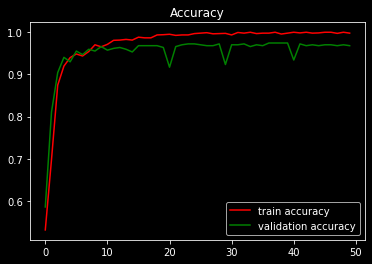

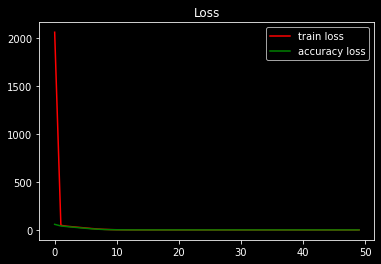

In [9]:
import matplotlib.pyplot as plt

acc = cnn_history.history['accuracy']
loss = cnn_history.history['loss']

val_acc = cnn_history.history['val_accuracy']
val_loss = cnn_history.history['val_loss']

epochs = range(len(acc))

plt.style.use('dark_background')
plt.figure()

plt.plot(epochs, acc, 'r', label='train accuracy')
plt.plot(epochs, val_acc, 'g', label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='train loss')
plt.plot(epochs, val_loss, 'g', label='accuracy loss')
plt.title('Loss')
plt.legend()

plt.show()

Accuracy: 96.82%
15/15 [==============================] - 0s 4ms/step - loss: 0.4769 - accuracy: 0.9682
acc=0.97 loss=0.48


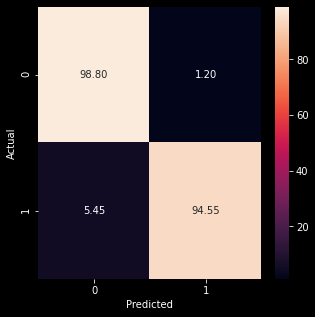

In [10]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def create_confusion_matrix(y_pred, y_test):    

  cm = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(5,5))
  target_names = [0, 1]
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)    

# make predictions for test data
# y_pred = trained_cnn_model.predict_classes(X_test)
y_pred = np.argmax(trained_cnn_model.predict(X_test), axis=1)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print score
loss, acc = trained_cnn_model.evaluate(X_test, test_cat)
print("acc={:.2f} loss={:.2f}".format(acc, loss))

create_confusion_matrix(y_pred, y_test)

In [11]:
trained_cnn_model.load_weights('best_model.h5')

test_loss, test_acc = trained_cnn_model.evaluate(X_test, test_cat)
print('test_loss', test_loss, 'test_acc', test_acc)

trained_cnn_model.summary()

15/15 [==============================] - 0s 5ms/step - loss: 0.4481 - accuracy: 0.9745
test_loss 0.4481212794780731 test_acc 0.9745222926139832
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 16)        6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 

Accuracy: 97.45%
15/15 [==============================] - 0s 4ms/step - loss: 0.4481 - accuracy: 0.9745
acc=0.97 loss=0.45


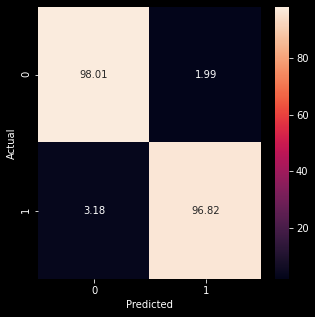

In [12]:
# make predictions for test data
# y_pred = trained_cnn_model.predict_classes(X_test)
y_pred = np.argmax(trained_cnn_model.predict(X_test), axis=1)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print score
loss, acc = trained_cnn_model.evaluate(X_test, test_cat)
print("acc={:.2f} loss={:.2f}".format(acc, loss))

create_confusion_matrix(y_pred, y_test)

In [16]:
def kf_validation(X_std, y, _clf_, rounds=1, verbose=False):
  import numpy as np
  from sklearn.model_selection import KFold
  from sklearn import svm
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import confusion_matrix
  import matplotlib.pyplot as plt
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras.utils import to_categorical
  from functools import reduce

  scores = []
  CM = np.zeros_like(np.eye(4))
  cm_seq = []

  for _ in range(rounds):

    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X_std)

    for train_index, test_index in kf.split(X_std):
      # print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X_std[train_index], X_std[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # C = 1.0
      # clf = _clf_
      # clf = keras.models.load_model(_clf_)

      # keras.backend.clear_session()
      # clf.fit(X_train, to_categorical(y_train), batch_size=64, epochs=50, verbose=False)

      cnn_model = build_cnn_model("relu", input_shape, verbose=False)
      clf, cnn_history = compile_and_fit_model(cnn_model, X_train, to_categorical(y_train), 
                                               X_test, to_categorical(y_test), 
                                               64, 50, 
                                               verbose=False)

      clf.load_weights('best_model.h5')

      y_pred = np.argmax(clf.predict(X_test), axis=1)
      score = 100*accuracy_score(y_test, y_pred)
      scores.append(score)
      print('Accyracy: {:.2f}%'.format(score))  
      loss, acc = clf.evaluate(X_test, to_categorical(y_test))
      # print("acc={:.2f} loss={:.2f}".format(acc, loss))

      cm = confusion_matrix(y_test, y_pred)
      # print(cm)
      # CM = CM + cm
      cm_seq.append(cm.copy())

  # print('\nDokładność uśredniona: {:.2f}%'.format(sum(scores)/len(scores)))  

  from sklearn.metrics import confusion_matrix
  import seaborn as sns

  # cm = CM
  cm = reduce(np.add, cm_seq)
  # print(cm)
  
  # cm = CM
  # Normalise
  cmn = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  if verbose==True:
    fig, ax = plt.subplots(figsize=(6,5))
    target_names = [0, 1]
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

    print()

  # Std devs
  cm_seq = np.array(cm_seq)
  # cmn_std = 100 * np.divide(cm_seq.std(axis=2), cm_seq.sum(axis=2))
  cumulative = []
  for item in cm_seq:
    c_ = 100 * item.astype('float') / item.sum(axis=1)[:, np.newaxis]
    cumulative.append(c_)

  cmn_std = np.array(cumulative).std(axis=0)  

  if verbose==True:
    fig, ax = plt.subplots(figsize=(6,5))
    target_names = [0, 1]
    sns.heatmap(cmn_std, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

    scores_mean = np.array(scores).mean()
    scores_std = np.array(scores).std()

  return (cmn, cmn_std, scores_mean, scores_std)

Accyracy: 98.09%
15/15 [==============================] - 0s 7ms/step - loss: 1.9453 - accuracy: 0.9809
Accyracy: 98.73%
15/15 [==============================] - 0s 6ms/step - loss: 1.9529 - accuracy: 0.9873
Accyracy: 98.51%
15/15 [==============================] - 0s 5ms/step - loss: 1.9389 - accuracy: 0.9851
Accyracy: 98.09%
15/15 [==============================] - 0s 5ms/step - loss: 1.9872 - accuracy: 0.9809
Accyracy: 98.51%
15/15 [==============================] - 0s 6ms/step - loss: 2.0506 - accuracy: 0.9851
Accyracy: 98.51%
15/15 [==============================] - 0s 6ms/step - loss: 1.9363 - accuracy: 0.9851
Accyracy: 98.09%
15/15 [==============================] - 0s 5ms/step - loss: 1.9520 - accuracy: 0.9809
Accyracy: 98.51%
15/15 [==============================] - 0s 5ms/step - loss: 1.9123 - accuracy: 0.9851
Accyracy: 97.88%
15/15 [==============================] - 0s 6ms/step - loss: 1.9364 - accuracy: 0.9788
Accyracy: 98.51%
15/15 [==============================] - 0s 5ms

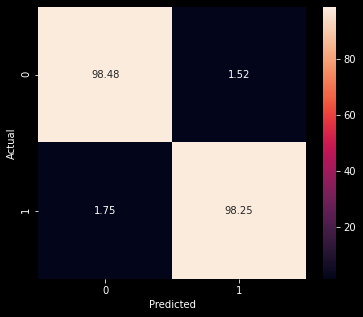

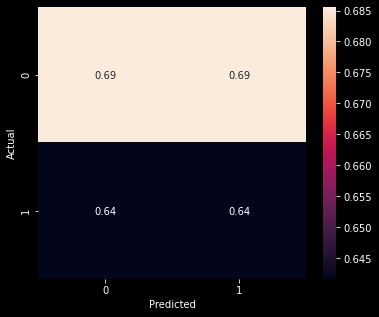

Average accuracy:  98.37150472060353
Std dev accuracy:  0.33547639923361566
#########################################################
time:  760.4437227249146
#########################################################


In [17]:
# for _ in range(5):
# cm, cm_std = kf_validation(X_std, y, trained_cnn_model, verbose=True)
cm, cm_std, acc_mean, acc_std = kf_validation(X_std, y, 'init.model.h5', rounds=30, verbose=True)

print('Average accuracy: ', acc_mean)
print('Std dev accuracy: ', acc_std)
end  = time.time()
print('#########################################################')
print("time: ",end-begin)
print('#########################################################')

In [18]:
print(np.round(cm,2))
print(np.round(cm_std,2))

[[98.48  1.52]
 [ 1.75 98.25]]
[[0.69 0.69]
 [0.64 0.64]]


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  print("Name:", gpu.name, "  Type:", gpu.device_type)

